<a href="https://colab.research.google.com/github/rakirs3333/DeepFakeDetection/blob/main/deepfake_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 25 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=a71a2a91db9c24a90520d7fb657ac16e6539c91349ebce9a039fa863264eaa2e
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:
"""
WE ARE LOADING PREPROCESSED DATA FROM DRIVE TO video_files VARIABLE
AND GETTING FRAME COUNT AND TOTAL NUMBER OF VIDEOS
"""
import glob
import numpy as np
import cv2
import random

# try getting celeb df and faceforensics++
video_files =  glob.glob('/content/drive/My Drive/Celeb_fake_face_only/*.mp4')
video_files += glob.glob('/content/drive/My Drive/Celeb_real_face_only/*.mp4')
video_files += glob.glob('/content/drive/My Drive/DFDC_FAKE_Face_only_data/*.mp4')
video_files += glob.glob('/content/drive/My Drive/DFDC_REAL_Face_only_data/*.mp4')
video_files += glob.glob('/content/drive/My Drive/FF_Face_only_data/*.mp4')

frame_count = []
for video_file in video_files[:]:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count)
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

In [ ]:
import pandas as pd
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/My Drive/metadata.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake

In [ ]:
import torch
import torchvision
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

class video_dataset(Dataset):

    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        temp_video = video_path.split('/')[-1]
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames,label

    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image

#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image) #splits into single channels
    image = cv2.merge((r,g,b)) #merges the channels
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [ ]:
import random
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

header_list = ["file","label"]
labels = pd.read_csv('/content/drive/My Drive/metadata.csv',names=header_list)

random.shuffle(video_files)
random.shuffle(video_files)
random.shuffle(video_files)

train_videos=video_files[:int(0.7*len(video_files))]
valid_videos=video_files[int(0.7*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))


print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


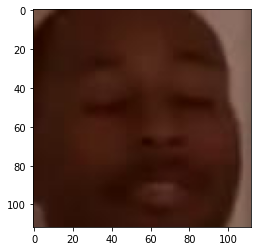

In [ ]:
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])


train_data = video_dataset(train_videos,labels,sequence_length = 40,transform = train_transforms)
val_data = video_dataset(valid_videos,labels,sequence_length = 40,transform = train_transforms)

train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)

image,label = train_data[0]
im_plot(image[0,:,:,:])

In [ ]:
# MODEL CREATION
from torch import nn
from torchvision import models

class Model(nn.Module):

    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [ ]:
# MODEL INSTANTIATION

model = Model(2).cuda()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [ ]:
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    torch.save(model.state_dict(),'/content/checkpoint.pt')

In [ ]:
lr = 1e-5
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss().cuda()

for epoch in range(num_epochs):
    train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    print("epoch",epoch,"complete")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 0 complete
epoch 1 complete
epoch 2 complete
epoch 3 complete
epoch 4 complete
epoch 5 complete
epoch 6 complete
epoch 7 complete
epoch 8 complete
epoch 9 complete
epoch 10 complete
epoch 11 complete
epoch 12 complete
epoch 13 complete
epoch 14 complete
epoch 15 complete
epoch 16 complete
epoch 17 complete
epoch 18 complete
epoch 19 complete


In [ ]:
def test(model, data_loader ,criterion):
    model.eval()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            outputs = model(inputs)
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
    return true,pred



In [ ]:
model = Model(2).cuda()
path_to_model = '/content/drive/My Drive/Deepfake models/model_40.pt'
model.load_state_dict(torch.load(path_to_model))
model.eval()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-5,weight_decay = 1e-5)
criterion = nn.CrossEntropyLoss().cuda()
true,pred= test(model,valid_loader,criterion)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(true,pred))

[[246  49]
 [ 65 295]]


In [ ]:
accuracy=(246+295)/655

In [ ]:
print(accuracy)

0.8259541984732824
